In [1]:
import os
import torch
import torchaudio
from utils import stereo_to_mono

data_dir = './fma/data/fma_small'
output_dir = './fma/data/waveforms'
sampling_rate = 22_050
max_ms = 30_000
SUBSAMPLING = False

# create the output directory if it doesn't exist
if not os.path.exists(output_dir):
    os.makedirs(output_dir)
    
# loop through all MP3 files in the data directory
for root, dirs, files in os.walk(data_dir):
    for filename in files:
        if filename.endswith('.mp3'):
            try:
                filepath = os.path.join(root, filename)
                sig, sr = torchaudio.load(filepath)
                sig = stereo_to_mono(sig) 
    
                # resample to the desired sampling rate
                if sr != sampling_rate:
                    sig = torchaudio.transforms.Resample(sr, sampling_rate)(sig)     
            
                if SUBSAMPLING:
                    subsample_length = sampling_rate * 5  # 5 seconds
                    overlap = int(subsample_length * 0.25)  # 25% overlap
                    subsamples = []
                    shift = subsample_length - overlap
                    for i in range(0, sig.size(0) - subsample_length + 1, shift):
                        subsample = sig[i:(i + subsample_length)]
                        subsamples.append(subsample)

                        if len(subsamples) == 7: break
            
                    # ignore samples that have less than 30s (it should not be the case but there is a 15s sample in validation dataset we dont know why)
                    if len(subsamples) != 7: continue
                    
                    for idx, subsample in enumerate(subsamples): 
                        # save the spectrogram to the output directory
                        output_file = os.path.join(output_dir, filename[:-4] + f'_{idx}.pt')
                        torch.save(subsample, output_file)
                    
                else:
                    # resize to a fixed length
                    sig_len = sig.shape[0]
                    max_len = sampling_rate//1000 * max_ms
                    if sig_len > max_len:
                        sig = sig[:max_len]
                    elif sig_len < max_len:
                        padding = max_len - sig_len
                        padding_tensor = torch.zeros((padding, sig.shape[1]))
                        sig = torch.cat((sig, padding_tensor), dim=0)

                    # save the spectrogram to the output directory
                    output_file = os.path.join(output_dir, filename[:-4] + '.pt')
                    torch.save(sig, output_file)
            except:
                continue
            

In [1]:
import torch
sp = torch.load('./fma/data/waveforms/052000.pt')

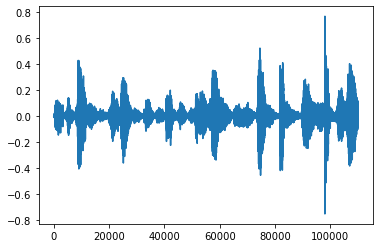

In [4]:
from matplotlib import pyplot as plt
plt.plot(sp[:110000])